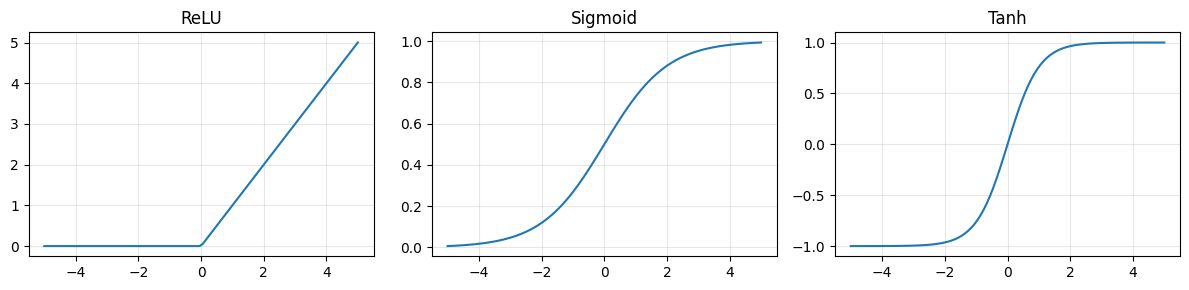

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)

plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(x, np.maximum(0, x))
plt.title('ReLU')
plt.grid(True, alpha=0.3)

plt.subplot(132)
plt.plot(x, 1/(1+np.exp(-x)))
plt.title('Sigmoid')
plt.grid(True, alpha=0.3)

plt.subplot(133)
plt.plot(x, np.tanh(x))
plt.title('Tanh')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(pred, y)

        # 3. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        # 4. Update weights
        optimizer.step()

        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f}")

In [ ]:

def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.294016
loss: 0.675277
loss: 0.279520
loss: 0.200578
loss: 0.265312
loss: 0.429237
loss: 0.101135
loss: 0.284863
loss: 0.356906
loss: 0.415463
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.119141 

Epoch 2
-------------------------------
loss: 0.317857
loss: 0.146834
loss: 0.074581
loss: 0.042222
loss: 0.181688
loss: 0.044204
loss: 0.079501
loss: 0.058541
loss: 0.065798
loss: 0.058511
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.089939 

Epoch 3
-------------------------------
loss: 0.038687
loss: 0.052739
loss: 0.132491
loss: 0.201121
loss: 0.062198
loss: 0.068146
loss: 0.164696
loss: 0.192052
loss: 0.144759
loss: 0.254096
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.083556 

Epoch 4
-------------------------------
loss: 0.082209
loss: 0.095615
loss: 0.038020
loss: 0.109827
loss: 0.112425
loss: 0.399768
loss: 0.220462
loss: 0.146779
loss: 0.194780
loss: 0.160171
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.082537 



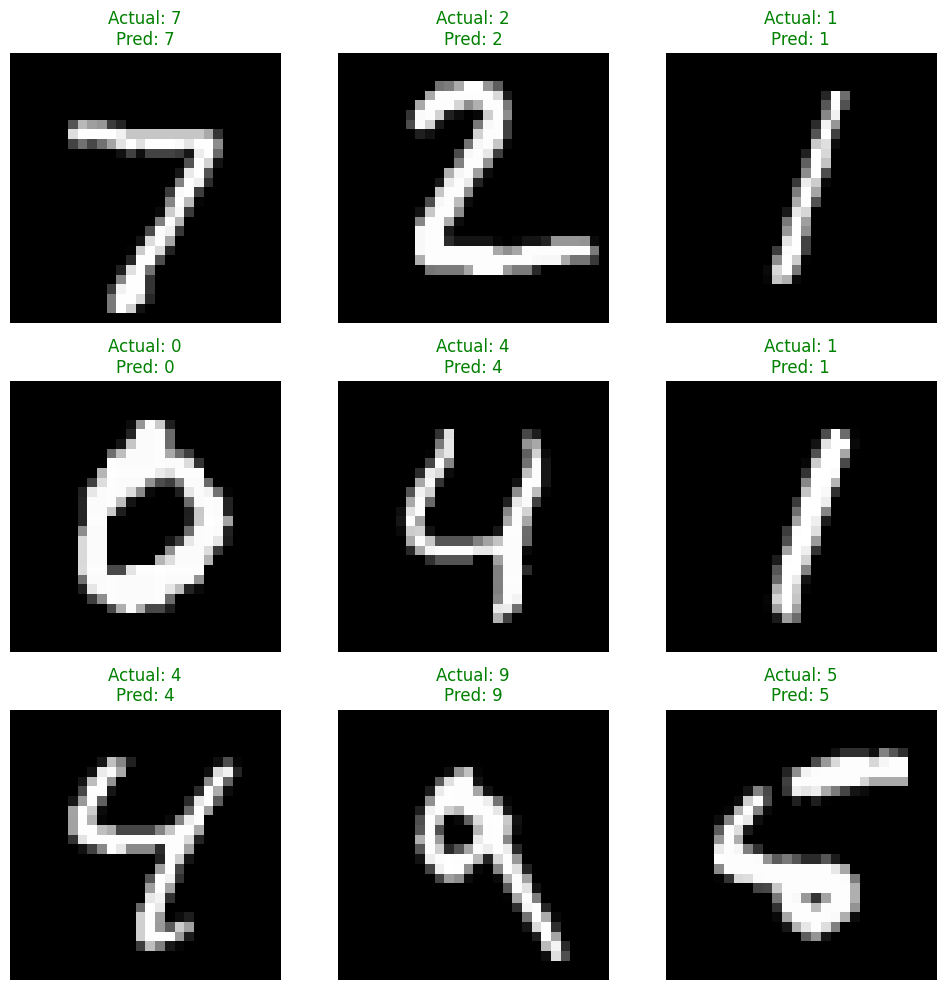

In [ ]:
def visualize_predictions(model, dataloader):
    model.eval()
    # Get one batch of test images
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        # Get the class with the highest score
        preds = outputs.argmax(1)

    # Move data to CPU for plotting
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Plot the first 9 images in the batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        # Set title color to green if correct, red if wrong
        color = "green" if labels[i] == preds[i] else "red"
        plt.title(f"Actual: {labels[i]}\nPred: {preds[i]}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Run the visualization!
visualize_predictions(model, test_dataloader)